## Notebook 3: Intro to Natural Language Processing.

### Project Goal: 

This project uses a Kaggle database of over 129,000 wine reviews from Wine Enthusiast/Wine Magazine. The data contains information related to variety, price, rating, and tasting notes. My desired outcome is to create a wine recommender that, when a user inputs a wine name, it will recommend a similar wine. The similarity will be based on variety, tasting notes, and price. 

### What's in This Notebook
In this notebook, I conduct some preliminary natural language processing (NLP) in which I use Count Vectoraization to identify the most common words used in the tasting note "description." I also use CVEC, Term-Frequency Inverse Document Frequency and Logistic Regression to as well as create a model to predict the wine varietal, Chardonnay. Then, I examine the correct and incorrect predictions using KMeans clustering. 

In [48]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('./datasets/wine.csv')

In [3]:
df.shape

(73691, 15)

## Fun with WordClouds!

As a fun introduction to this workbook, I created a wordclouds for California Chardonnarys and California Cabernets. 

This exercise is actually useful for transitioning to the next part in the recommender project, which will be digging into the descriptions and trying to find common words. 

To begin, I isolate descriptions for California Chardonnays and California Cabernets and save them as separate .csv files, which I load here. 

In [4]:
CAChards = pd.read_csv('./datasets/CAChards.csv')

In [5]:
CACabs = pd.read_csv('./datasets/CACabs.csv')

When I first ran the wordclouds, the most common word was "WINE" and "FLAVOR", which was not helpful, so I made those stopwords, in addition to the variety names. 

In [6]:
stopwords = set(STOPWORDS)
stopwords.add("wine")
stopwords.add("flavor")
stopwords.add("flavors")
stopwords.add("chardonnay")
stopwords.add("cab")
stopwords.add("cabernet")

In [7]:
wordcloud = WordCloud(stopwords = stopwords).generate(' '.join(CAChards['Description']))
wordcloud2 = WordCloud(stopwords=stopwords).generate(' '.join(CACabs['description']))

#### California Chardonnay Wordcloud

The most used words I'm seeing are pineapple, buttered toast, fruit, green apple, rich. I see a "chard" in there, so should probably include that as a stop word in a later interation. 

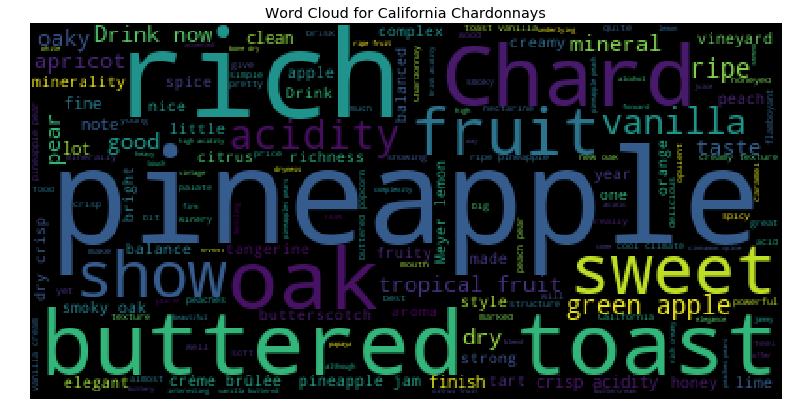

In [10]:
plt.figure(figsize=(12,9))
plt.title("Word Cloud for California Chardonnays")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### California Cabernet Wordcloud

By contrast, the most common words I see for cabernets are tannin, black currant, oak, dry, and also fruit and rich, which were also found above. 

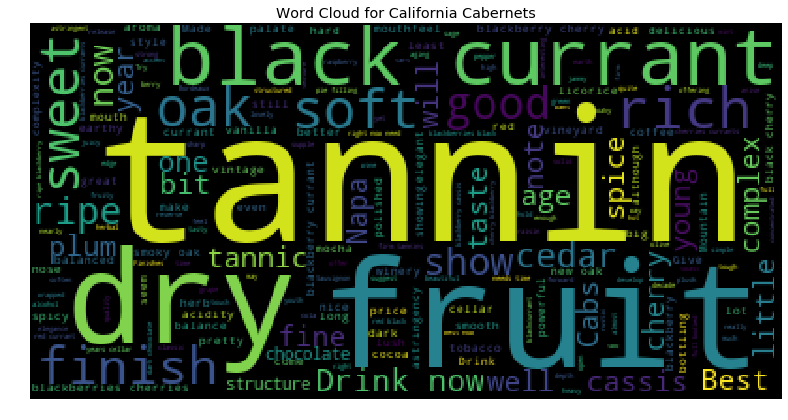

In [11]:
plt.figure(figsize=(12,9))
plt.title("Word Cloud for California Cabernets")
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Natural Language Processing

Okay, enough of the pretty pictures. In this section, I use NLP tools of Count Vectorization and TF-IDF to explore the description variable. 

For Count Vectorization, I'll take a sample of the 70,000 rows so as not to crash my kernel! 

In [12]:
from random import sample
sample_text = df['description'].sample(5000)

In [17]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

In [19]:
my_additional_stop_words = ['wine', 'flavor', 'flavors', 'notes', 'offers', 'enjoy', 'drink', 'bottling',
                           'really', 'reveal', 'picked', 'partner', 'thanks', 'grown', 'gain', 
                           'thanks', 'percentage', 'buy', 'mid', 'gain', 'bottle', 'amid', 'available',
                           'come', 'aspect', 'try', 'pinot', 'noir', 'chardonnay','cabernet', 'sauvignon',
                            'red','white','bordeaux', 'riesling', 'blanc','syrah','merlot',
                            'rose', 'zinfandel','malbec','nebbiolo','sangiovese', 'tempranillo','sparkling',
                            'rhone','gris', 'riesling', 'sirah', 'petite', 'petit', 'make']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

This code fits and transforms the sample text and gives the most common words in the sample of descriptions. Fruit, finish, aromas, cherry, palate, acid, tannin, black, dry are used quite commonly. 

In [20]:
cvec = CountVectorizer(stop_words=stop_words, tokenizer=tokenize, max_features = 2000)

cvec.fit(sample_text)

new_df  = pd.DataFrame(cvec.transform(sample_text).todense(),
             columns=cvec.get_feature_names()).sum(axis=0)

most_common_words = new_df.transpose().sort_values(0, ascending=False).transpose()
most_common_words.head(20)

fruit         2284
finish        1574
aroma         1491
cherri        1480
palat         1462
acid          1418
tannin        1350
black         1196
dri           1057
note          1034
ripe           999
spice          898
rich           850
oak            815
berri          776
fresh          723
nose           678
blackberri     676
light          645
sweet          626
dtype: int64

### Predicting the Chardonnay varietal from the descriptions

In [21]:
df['Chard'] = df['variety'] == "Chardonnay"

Here I see I have a good many Chardonnays in the dataset to try to predict. The baseline accuracy would be about 87% so let's see if the model does better than that.

In [22]:
df['Chard'] = df['Chard'].astype(int)
df['Chard'].value_counts()

0    64441
1     9250
Name: Chard, dtype: int64

In [23]:
def description(df):
    return df['description']

description_tf = FunctionTransformer(description, validate=False)

In [24]:
cv = CountVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000)
tf = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000)

In [25]:
lr = LogisticRegression()

I created a Pipeline and tried both CVEC and TF-IDF in the model, with similar results. I train-test split the data and use a Grid Search over some parameters (this takes awhile to run!). Min_df refers to ignoring words that appear infrequently (I search over less than 1, 2, and 3%). Max_df refers to ignoring words that appear frequently (I search over words that appear in over 50% or 100% of the cases). I had the model look at 1 and 2 n-grams, so single words and words found together/double words. 

I end up with a very large accuracy score of .94. 

In [26]:
pipe = Pipeline([
    ("description_tf", description_tf),
    ("cv", cv),
#    ("tf", tf),
    ("lr", lr)
])

In [27]:
X = df[['description']]
y = df['Chard']

In [28]:
cross_val_score(pipe, X, y).mean()

0.9416074908112857

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [33]:
params = {}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9393681696460882


{}

In [34]:
gs.score(X_test, y_test)

0.9402920262715084

In [40]:
predictions = cross_val_predict(pipe, X, y)
df['predictions'] = predictions

In [41]:
df[['predictions', 'variety']].head(20);

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
cm = confusion_matrix(y, predictions)
cm

array([[62559,  1882],
       [ 2421,  6829]])

### Examining correct and incorrect predictions. 
Next, I want to see the types of words that are associated with correct and incorrect predictions. It is easy to see where the incorrect predictions happen as they share many similar words: Vanilla, Acid, Rich, Citrus, Apple. 

In [44]:
wrong_Chard = df.loc[df['predictions'] != df['Chard']]

#### KMeans cluster on the correct and incorrect predictions.

In [45]:
wrong_desc = wrong_Chard['description'].values

In [46]:
tf_vect = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000, ngram_range = (1,2)
X_wrong = tf_vect.fit_transform(wrong_desc)
words_wrong_chard = tf_vect.get_feature_names()

In [49]:
kmeans = KMeans(n_clusters = 5, n_init = 5, n_jobs = -1)
kmeans.fit(X_wrong)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [51]:
chard = df.loc[df['variety'] == "Chardonnay"]

In [52]:
chard_desc = chard['description'].values

In [53]:
tf_vect = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000
X_chard = tf_vect.fit_transform(chard_desc)
words_chard = tf_vect.get_feature_names()

In [55]:
kmeans = KMeans(n_clusters = 5, n_init = 5, n_jobs = -1)
kmeans.fit(X_chard)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Common words used to describe the incorrect predictions

In [50]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_wrong_chard[word] for word in centroid))

0 : ripe, fruit, acid, textur, fruiti, rich, age, charact, crisp, readi, miner, fresh, soft, wood, attract
1 : oak, fruit, sweet, acid, vanilla, pineappl, tast, dri, rich, finish, like, barrel, tropic, ferment, peach
2 : lemon, lime, appl, palat, nose, acid, pear, fresh, green, finish, lemon lime, green appl, aroma, crisp, light
3 : medium bodi, medium, bodi, finish, aroma, fruit, textur, appl, note, light, palat, fresh, crisp, acid, pear
4 : aroma, finish, palat, appl, fruit, note, citrus, pear, peach, fresh, light, feel, melon, nose, offer


#### Common words used to describe Chardonnay:

In [57]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_chard[word] for word in centroid))

0 : butter toast, butter, toast, pineappl, vanilla, jam, sweet, oak, acid, orang, rich, oaki, fruit, toast vanilla, pineappl jam
1 : finish, aroma, appl, palat, bodi, note, pear, medium, fruit, fresh, light, melon, feel, citrus, medium bodi
2 : oak, fruit, acid, pineappl, rich, tropic, sweet, peach, dri, tropic fruit, miner, ripe, pear, vanilla, appl
3 : fruit, ripe, textur, acid, age, wood, rich, crisp, charact, miner, fruiti, yellow fruit, yellow, readi, fresh
4 : nose, lemon, palat, lime, appl, bottl, salt, aroma, sea, nose bottl, sea salt, pear, touch, pith, sip
